In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = [ 'SBI', 'SBIVOL', 'BAJAJFIN', 'FEDBANK', 'ICICI']
target_column = ['SBI']
features = df[feature_columns]
target = df[target_column].shift(-2)

new_data1 = 758.30
target.iloc[-2, 0] = new_data1

new_data2 = 766.40
target.iloc[-1, 0] = new_data2
target.tail(5)

,SBI
3748,740.049988
3749,733.299988
3750,752.349976
3751,758.300000
3752,766.400000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5 # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_sbi2h_0.9724.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9724
MAPE: 0.0211
RMSE: 14.4358
RMSE_normalizeddata: 0.0207
MAE_normalizeddata: 0.0158
MAE: 11.0365


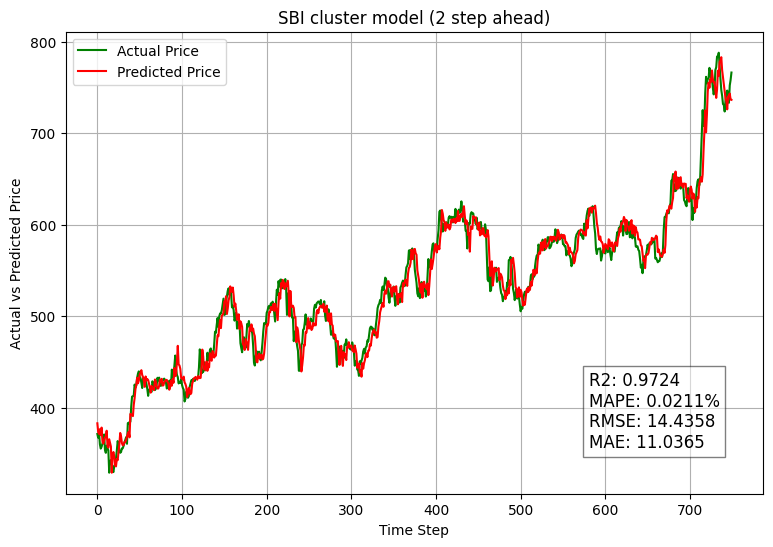

In [7]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('SBI cluster model (2 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('sbicluster_2sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2: 0.9662
MAPE: 0.0317
RMSE: 9.9775
RMSE_normalizeddata: 0.0143
MAE_normalizeddata: 0.0107
MAE: 7.4926


In [120]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8489e-04 - val_loss: 0.0019
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9139e-04 - val_loss: 0.0027
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8570e-04 - val_loss: 0.0014
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7044e-04 - val_loss: 0.0057
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.7683e-04 - val_loss: 0.0037
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6799e-04 - val_loss: 0.0020
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5514e-04 - val_loss: 0.0017
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7476e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5853e-04 - val_loss: 0.0014
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1686e-04 - val_loss: 0

In [121]:
model_lstm.save('model_lstm_bajajfin2h_1.keras')

In [122]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1011e-04 - val_loss: 0.0023
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6848e-04 - val_loss: 0.0020
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8559e-04 - val_loss: 0.0029
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9586e-04 - val_loss: 0.0017
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5856e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7443e-04 - val_loss: 0.0017
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4324e-04 - val_loss: 0.0031
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4801e-04 - val_loss: 0.0016
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3249e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3200e-04 - val_los

In [123]:
model_lstm.save('model_lstm_bajajfin2h_2.keras')

In [124]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0059 - val_loss: 0.0081
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.9647e-04 - val_loss: 0.0013
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5705e-04 - val_loss: 0.0014
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.9806e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9901e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4362e-04 - val_loss: 0.0011
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.8924e-04 - val_loss: 0.0014
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6514e-04 - val_loss: 9.6822e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5832e-04 - val_loss: 0.0018
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7714e-04 - val_loss: 8.9281e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3725e-04 -

In [125]:
model_lstm.save('model_lstm_bajajfin2h_3.keras')

In [126]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.6949e-04 - val_loss: 0.0044
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6450e-04 - val_loss: 0.0044
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9370e-04 - val_loss: 0.0015
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.1431e-04 - val_loss: 0.0021
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5766e-04 - val_loss: 0.0020
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.3700e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.7126e-04 - val_loss: 0.0015
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.5899e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3109e-04 - val_loss: 0.0018
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.1950e-04 - val_los

In [127]:
model_lstm.save('model_lstm_bajajfin2h_4.keras')

In [128]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9874e-04 - val_loss: 0.0021
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.8646e-04 - val_loss: 0.0023
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6835e-04 - val_loss: 0.0023
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5831e-04 - val_loss: 0.0026
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.5223e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7303e-04 - val_loss: 0.0015
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6914e-04 - val_loss: 0.0019
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.2754e-04 - val_loss: 0.0013
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6101e-04 - val_loss: 8.9802e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.5319e-04 - va

In [129]:
model_lstm.save('model_lstm_bajajfin2h_5.keras')

In [130]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7150e-04 - val_loss: 0.0037
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.8219e-04 - val_loss: 0.0022
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.8907e-04 - val_loss: 0.0025
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9638e-04 - val_loss: 0.0017
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4185e-04 - val_loss: 0.0052
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8360e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4489e-04 - val_loss: 0.0012
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5777e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3337e-04 - val_loss: 0.0025
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7354e-04 - val_lo

In [131]:
model_lstm.save('model_lstm_bajajfin2h_6.keras')

In [132]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.8759e-04 - val_loss: 0.0023
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.5465e-04 - val_loss: 0.0020
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9302e-04 - val_loss: 0.0061
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7620e-04 - val_loss: 0.0014
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6078e-04 - val_loss: 0.0074
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.5918e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.8138e-04 - val_loss: 0.0054
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1995e-04 - val_loss: 0.0040
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6561e-04 - val_loss: 0.0012
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2959e-04 - val_lo

In [133]:
model_lstm.save('model_lstm_bajajfin2h_7.keras')

In [134]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.0311e-04 - val_loss: 0.0045
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.3363e-04 - val_loss: 0.0030
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.5373e-04 - val_loss: 0.0018
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3883e-04 - val_loss: 0.0015
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1.4909e-04 - val_loss: 0.0019
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5447e-04 - val_loss: 0.0017
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3702e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6459e-04 - val_loss: 0.0015
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.6922e-04 - val_loss: 0.0012
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.5775e-04 - val_loss

In [135]:
model_lstm.save('model_lstm_bajajfin2h_8.keras')

In [136]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.8670e-04 - val_loss: 0.0078
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7701e-04 - val_loss: 0.0041
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7920e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.1128e-04 - val_loss: 0.0014
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.6571e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5552e-04 - val_loss: 0.0026
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5080e-04 - val_loss: 0.0031
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9652e-04 - val_loss: 0.0015
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6289e-04 - val_loss: 0.0015
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.5666e-04 - val_loss

In [137]:
model_lstm.save('model_lstm_bajajfin2h_9.keras')

In [138]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0055 - val_loss: 0.0082
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.0876e-04 - val_loss: 0.0029
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2741e-04 - val_loss: 0.0127
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7689e-04 - val_loss: 0.0019
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5753e-04 - val_loss: 0.0018
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5905e-04 - val_loss: 0.0030
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7103e-04 - val_loss: 0.0019
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.4177e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5627e-04 - val_loss: 0.0021
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.6738e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.4330e-04 - val_lo

In [139]:
predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
R2: 0.9967
MAPE: 0.0664
RMSE: 80.3846
RMSE_normalizeddata: 0.0098
MAE_normalizeddata: 0.0046
MAE: 37.2633


In [140]:
model_lstm.save('model_lstm_bajajfin2h_10.keras')